## Intro to DL & OOD

### Resources
- LeCun, Y., Bengio, Y. and Hinton, G., 2015. [Deep Learning](https://www.nature.com/articles/nature14539). nature, 521(7553), pp.436-444.
- [Ignite documentation](https://pytorch-ignite.ai/)
- [PyTorch tutorials](https://pytorch.org/tutorials/) 
- [torchmetrics examples](https://torchmetrics.readthedocs.io/en/stable/pages/quickstart.html)
- [pyOODs](https://pyodds.com/implementedalgos.html)

![pytorch cheatsheet](./figs/pytorch-cheat.jpeg "pytorch cheatsheet")

Figure from [pytorch forum](https://discuss.pytorch.org/t/pytorch-cheat-sheet/72016)

#### We need to organize our files to be easy to use by data loader classes

In [1]:
import pandas as pd
import numpy as np

groundtruth = pd.read_csv("../data/ISIC2019/ISIC_2019_Training_GroundTruth.csv")
groundtruth = groundtruth.set_index("image")
oodist = list(groundtruth.index[groundtruth.AK == 1])
indist = list(groundtruth.index[groundtruth.NV == 1])

In [58]:
from pathlib import Path
import shutil

# get the path/directory
folder_dir = "../data/ISIC2019/ISIC_2019_Training_Input/"
# dest_ind_dir = "../data/isic_torch/test/0"
dest_outd_dir = "../data/isic_torch/test/1"
images = Path(folder_dir).glob("*.jpg")

for i in images:
    if i.stem in indist:
        pass
        # shutil.copy(i, dest_ind_dir)
    elif i.stem in oodist:
        shutil.copy(i, dest_outd_dir)

#### How to create a simple autoencoder?

![AE](./figs/ae.png "pytorch cheatsheet")

Figure from [towards data science](https://towardsdatascience.com/anomaly-detection-using-autoencoders-5b032178a1ea)

In [17]:
import torch
from models.ae import Autoencoder
from torchsummary import summary

ae = Autoencoder()

if torch.cuda.is_available():
    ae = ae.cuda()
summary(ae, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 16, 16]             588
              ReLU-2           [-1, 12, 16, 16]               0
            Conv2d-3             [-1, 24, 8, 8]           4,632
              ReLU-4             [-1, 24, 8, 8]               0
            Conv2d-5             [-1, 48, 4, 4]          18,480
              ReLU-6             [-1, 48, 4, 4]               0
   ConvTranspose2d-7             [-1, 24, 8, 8]          18,456
              ReLU-8             [-1, 24, 8, 8]               0
   ConvTranspose2d-9           [-1, 12, 16, 16]           4,620
             ReLU-10           [-1, 12, 16, 16]               0
  ConvTranspose2d-11            [-1, 3, 32, 32]             579
          Sigmoid-12            [-1, 3, 32, 32]               0
Total params: 47,355
Trainable params: 47,355
Non-trainable params: 0
---------------------------------

#### How to make the images ready for our Autoencoder?
- Dataset classes (e.g ImageFolder)
- Dataloader (How to iterate our dataset with DataLoader)
- Transformations (Preprocessing functions and augmentation techniques)

In [55]:
from torchvision import transforms as tfs

transforms_train = [
    tfs.RandomHorizontalFlip(p=0.5),
    tfs.RandomAutocontrast(p=0.5),
    tfs.RandomAdjustSharpness(p=0.5, sharpness_factor=0.7),
    tfs.RandomAffine(0, scale=(0.7, 1.0)),
    tfs.Resize((64, 64)),
    # tfs.Grayscale(1),
    tfs.ToTensor(),
    # tfs.Normalize(mean=0.46 ,std=0.32)
]

transforms_test = [
    tfs.Resize((64, 64)),
    # tfs.Grayscale(1),
    tfs.ToTensor(),
    # tfs.Normalize(mean=0.46 ,std=0.32)
]

In [56]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

image_data_train = ImageFolder(
    "../data/isic_torch/train/", transform=tfs.Compose(transforms_train)
)
image_data_test = ImageFolder(
    "../data/isic_torch/test/", transform=tfs.Compose(transforms_test)
)

In [57]:
data_loader_train = DataLoader(image_data_train, batch_size=50, shuffle=True)
data_loader_test = DataLoader(image_data_test, batch_size=50, shuffle=True)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])


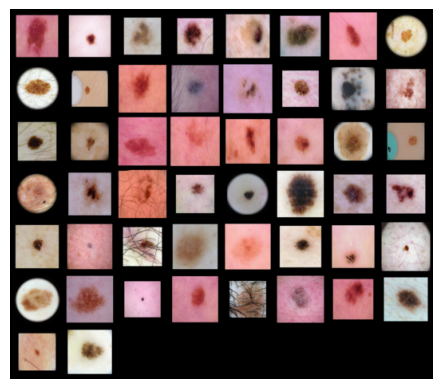

In [58]:
from aux import create_plot_window, imshow
import torchvision

dataiter = iter(data_loader_train)
images, labels = next(dataiter)
print(labels)
imshow(torchvision.utils.make_grid(images))

tensor([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1])


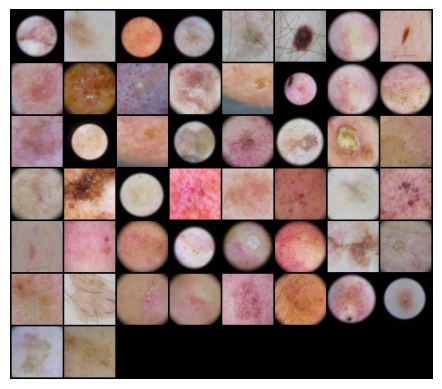

In [59]:
dataiter = iter(data_loader_test)
images, labels = next(dataiter)
print(labels)
imshow(torchvision.utils.make_grid(images))

#### After our data is loaded into PyTorch we will train our model
    - We need to define which criterion to use during trainig.
    - How to optimize our solution space.
    - Define which metrics to we want to follow during training.

In [9]:
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
import torchmetrics

device = "cpu"

ae = Autoencoder()
criterion = nn.BCELoss()
optimizer = optim.Adam(ae.parameters(), lr=0.0001, betas=(0.5, 0.999))

if torch.cuda.is_available():
    AE = ae.cuda()
    criterion.cuda()

In [10]:
from aux import get_torch_vars

epochs = 100

for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, _) in enumerate(data_loader_train, 0):
        inputs = get_torch_vars(inputs)

        # Forward Pass
        encoded, outputs = ae(inputs)
        loss = criterion(outputs, inputs)

        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.data
        if i % 50 == 49:  # print every 2000 mini-batches
            print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

[1,     1] loss: 0.696



KeyboardInterrupt



#### After our model is trained we can save the weights
- Use save and load functions
- Use the trained model with our test data
- Extract the reconstruction error and make a threshold

In [ ]:
torch.save(ae.state_dict(), "./weights/autoencoder.pkl")

In [60]:
ae = Autoencoder()
ae.load_state_dict(torch.load("./weights/autoencoder.pkl", map_location="cpu"))

<All keys matched successfully>

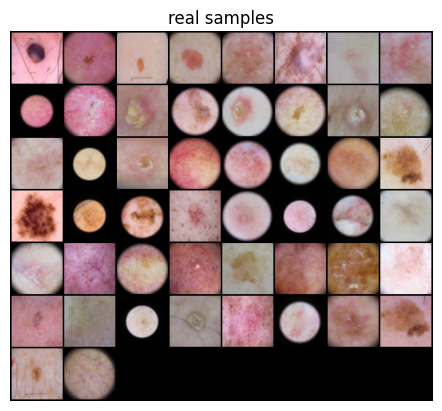

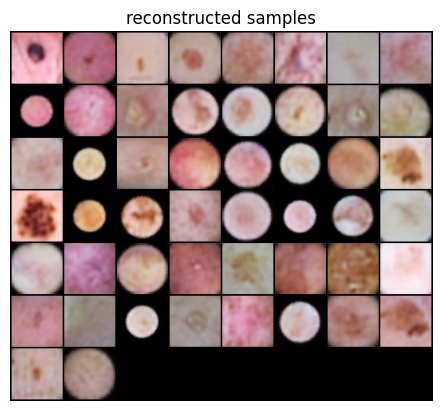

In [61]:
from torch.autograd import Variable
import matplotlib.pyplot as plt

dataiter = iter(data_loader_test)
images, labels = next(dataiter)

plt.title("real samples")
imshow(torchvision.utils.make_grid(images))

images = Variable(images)
labels, decoded_imgs = ae(images)
plt.title("reconstructed samples")
imshow(torchvision.utils.make_grid(decoded_imgs.data))

In [62]:
mse = nn.MSELoss(reduction="sum")
mse_test = list()
labels_test = list()

In [63]:
for i, (inputs, labels) in enumerate(data_loader_test, 0):
    for j in range(inputs.shape[0]):
        # print(inputs.shape)
        images = Variable(inputs)
        decoded_imgs = ae(images)[1]
        mse_test.append(mse(decoded_imgs[j], images[j]).item())
        labels_test.append(labels[j].detach().numpy().item())

In [64]:
assert len(labels_test) == len(mse_test)

In [65]:
import pandas as pd

error_df = pd.DataFrame({"re": mse_test, "labels": labels_test})

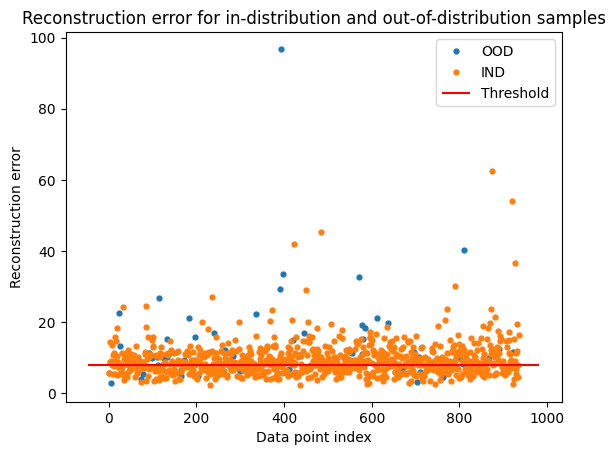

In [83]:
import matplotlib.pyplot as plt
from aux import plot_re

groups = error_df.groupby("labels")
threshold_fixed = 8

plot_re(groups, threshold_fixed)

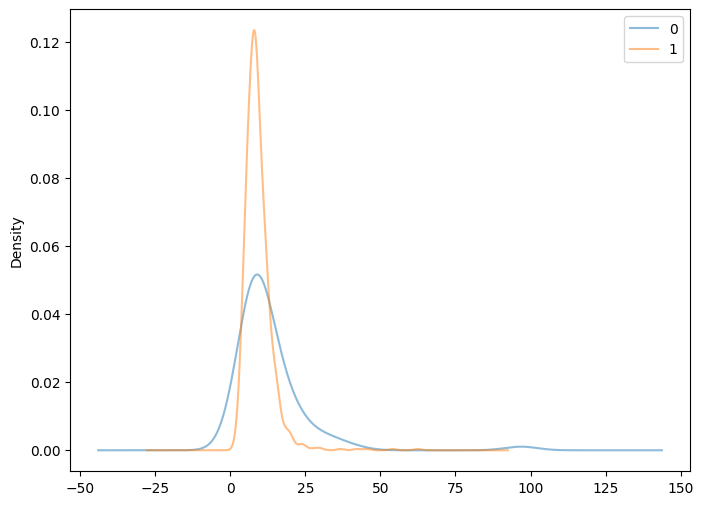

In [84]:
fig, ax = plt.subplots(figsize=(8, 6))
for label, df in error_df.groupby("labels"):
    df["re"].plot(kind="kde", ax=ax, label=label, alpha=0.5)
plt.legend()

In [86]:
error_df["output"] = error_df["re"].apply(lambda x: 0 if x <= threshold_fixed else 1)
error_df

,re,labels,output
0,5.783481,1,0
1,5.613879,1,0
2,14.482965,1,1
3,8.827790,1,1
4,8.763401,1,1
...,...,...,...
931,19.341711,1,1
932,11.862295,1,1
933,4.583340,1,0
934,7.848182,1,0


In [87]:
import torchmetrics

aucroc = torchmetrics.AUROC(task="binary")
1 - aucroc(
    torch.tensor(error_df["labels"].values), torch.tensor(error_df["output"].values)
)

tensor(0.5078)

In [88]:
from sklearn.metrics import classification_report

print(
    classification_report(
        error_df["labels"].values,
        error_df["output"].values,
        target_names=["In-distribution", "Out-distribution"],
    )
)

                  precision    recall  f1-score   support

 In-distribution       0.06      0.36      0.11        69
Out-distribution       0.92      0.58      0.71       867

        accuracy                           0.57       936
       macro avg       0.49      0.47      0.41       936
    weighted avg       0.86      0.57      0.67       936



## Malaria Study 

#### TODO by team

- Load folder structure needed for pytorch
- Define transformations, create DataLoaders
- Train AE, inspect reconstruction error and other metrics